In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
year = '19'

Open data files and transform them into pandas dataframe

In [4]:
f = uproot.pandas.iterate("../outputs/"+year+"/*.root", "t", branches=['label', 'be', 'm', 't', 'proc'])
data = pd.concat([j for j in f])

Sort values by label

In [5]:
data.sort_values(by='label', ascending=True, inplace=True);

Cut off incorrect beam energy and mass outside the window

In [6]:
data.query('be>0&m>450&m<550&proc!=1', inplace=True)
if not(year=='model'):
    data.query('t>-1', inplace=True)

Change index column

In [7]:
data.index = data.label
data.drop(['label', 'proc'], axis=1, inplace=True)

Include luminosity file

In [8]:
lum = pd.read_csv('../inputs/'+year+'/lum', header=None, names=['label', 'lum'])

In [9]:
lum = lum.drop_duplicates(subset=['label'])

In [10]:
lum.index = lum.label
lum.drop(['label'], axis=1, inplace=True)

In [11]:
lum.shape

(43, 1)

Check right values of triggers

In [12]:
data.groupby('t').agg({'m':np.size})

,m
t,
0,1256.0
1,224.0
2,8203.0


In [13]:
data.head()

,be,m,t
label,,,
537.5,537.454102,500.687988,2
537.5,537.454102,504.187775,2
537.5,537.454102,499.756104,2
537.5,537.454102,492.776550,0
537.5,537.454102,491.207275,0


In [14]:
lum.sort_index()

,lum
label,
537.5,1221.9
550.0,1427.2
550.1,499.5
562.5,1049.2
575.0,1058.9
587.5,1169.9
600.0,1165.5
612.5,1062.5
625.0,1093.3


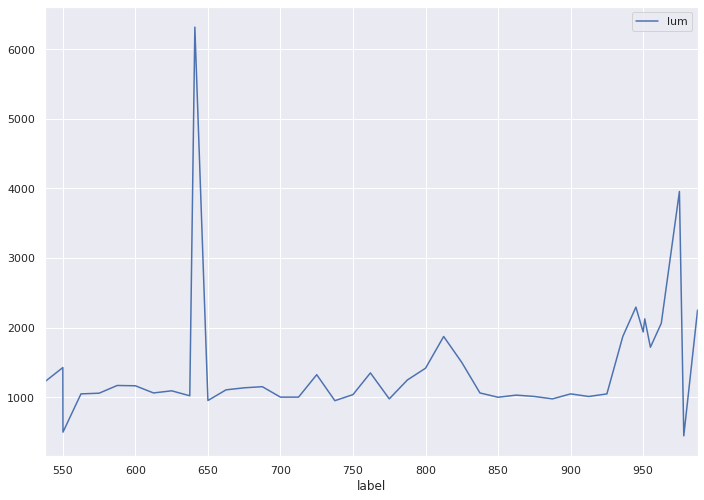

In [15]:
lum.sort_index().plot()

Join luminosity to data file

In [16]:
data = data.join(lum, how='inner')

In [17]:
lum.drop_duplicates().sort_index().tail()

,lum
label,
955.0,1719.2
962.5,2062.9
975.0,3955.9
978.0,446.2
987.5,2252.5


See how much events in each point I have

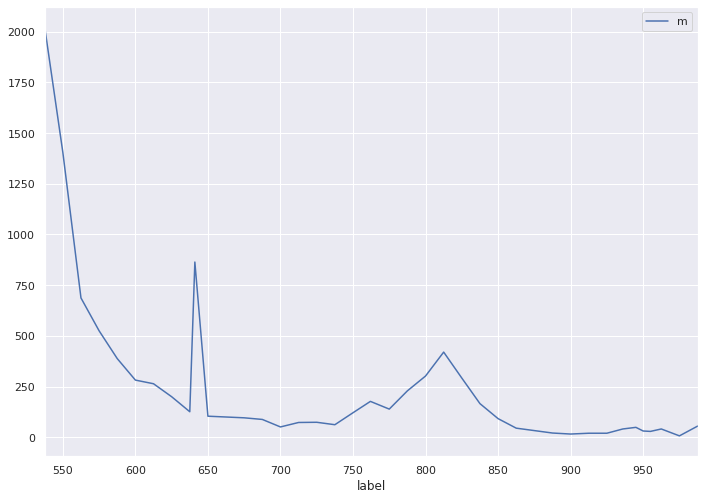

In [18]:
data.groupby('label').agg({'m':np.size}).plot()

In [19]:
data.groupby('label').agg({'m':np.size})

,m
label,
537.5,2022.0
550.0,1405.0
562.5,687.0
575.0,525.0
587.5,388.0
600.0,282.0
612.5,264.0
625.0,200.0
637.5,126.0


Next stage: merge points with little data

In [20]:
cnct = [] #model
#cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), ([942., 950., 971.], 960), 
#        ([981., 990, 1003.5],990)] #17 year
#cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
#cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year

In [21]:
data['label'] = data.index
for c in cnct:
    data.label.replace(c[0], c[1], inplace=True)
data.index = data.label
data.drop(['label'], axis=1, inplace=True)

OK, points have been merged

In [22]:
data.tail()

,be,m,t,lum
label,,,,
987.5,987.804626,519.291504,2,2252.5
987.5,987.804626,513.790405,2,2252.5
987.5,987.804626,514.808411,2,2252.5
987.5,987.804626,491.808868,2,2252.5
987.5,987.804626,485.778198,2,2252.5


Get true luminosity for merged events

In [23]:
data['lume'] = data.be*data.lum

Create new table with right values of energy and luminosity

In [24]:
new_lum = data[['be','lum', 'lume']].drop_duplicates().groupby('label').agg({'lume':[np.sum], 'lum':[np.sum], 
                        'be':[np.min, np.max]})

In [25]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [26]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [27]:
new_lum.tail()

,lum,dEmin,dEmax,Emean
label,,,,
950.0,1937.9,0.0,0.0,950.15
955.0,1719.2,0.0,0.0,956.05
962.5,2062.9,0.0,0.0,962.82
975.0,3955.9,0.0,0.0,976.21
987.5,2252.5,0.0,0.0,987.80


I have got new luminosity table.

Now I should joint it to existing table

In [28]:
data.drop(['lume', 'lum', 'be'], axis=1, inplace=True)
data = data.join(new_lum, how='inner')

That is good. Now I should do the analysis

In [29]:
data.tail()

,m,t,lum,dEmin,dEmax,Emean
label,,,,,,
987.5,519.291504,2,2252.5,0.0,0.0,987.8
987.5,513.790405,2,2252.5,0.0,0.0,987.8
987.5,514.808411,2,2252.5,0.0,0.0,987.8
987.5,491.808868,2,2252.5,0.0,0.0,987.8
987.5,485.778198,2,2252.5,0.0,0.0,987.8


----------------
## Fit

In [30]:
data2 = data.groupby('label')

In [31]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['m'] )

537.5
550.0
562.5
575.0
587.5
600.0
612.5
625.0
637.5
641.0
650.0
675.0
687.5
700.0
712.5
725.0
737.5
750.0
762.0
775.0
787.5
800.0
812.5
825.0
837.5
850.0
862.5
887.5
900.0
912.5
925.0
936.0
945.0
950.0
955.0
962.5
975.0
987.5


In [32]:
import iminuit
import probfit as pf

In [33]:
mass_bound = (450, 550)

In [34]:
def constant(x):
    return 1
norm_bkg = pf.Normalized( constant, mass_bound )
norm_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

gauss1 = pf.Extended(pf.rename(pf.gaussian, ['x', 'm', '$\sigma$']), extname='$N_{sig}$')

pdf = pf.AddPdf(gauss1, norm_bkg)
pf.describe(pdf)

['x', 'm', '$\\sigma$', '$N_{sig}$', '$N_{bkg}$']

In [35]:
plt.rcParams.update({'font.size': 20, 'figure.figsize':(11.7,8.27)})

In [74]:
def fitter(dic, nbins):
    #likelihood = pf.BinnedLH(pdf, dic, nbins, bound=mass_bound, extended=True)
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound)
    initial_par_values = {"m":497.6, "$\sigma$":8.6, "$N_{sig}$":np.size(dic), "$N_{bkg}$":1}
    errors = {"error_m": 1, "error_$\sigma$": 0.1, "error_$N_{sig}$": 0.3, "error_$N_{bkg}$":0}
    limits = {"limit_m": [485, 500], "limit_$\sigma$": [2, 15], "limit_$N_{sig}$": [1, 10000], "limit_$N_{bkg}$": [0, 1000]}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
    likelihood.draw(minuit=mt)
    plt.tick_params(labelsize=20);
    plt.xlabel('Energy, MeV', fontsize=20)
    plt.ylabel('number of events', fontsize=20)
    #plt.savefig('tutu.svg')
    return mt, likelihood

Create table for the final result

In [37]:
N_dic = dict()
itr = iter(dic)

Go, go, go

In [121]:
i = next(itr)
print('Label:', i)

StopIteration: 

Migrad quality: True
Real: 55 Found: 55.00300226933224


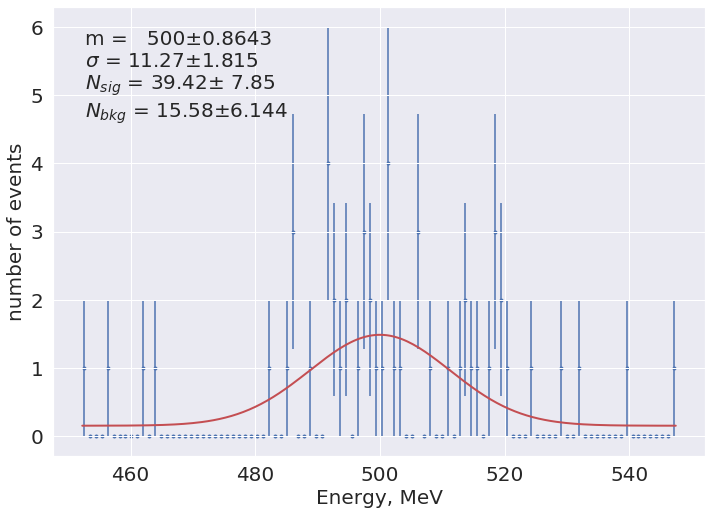

In [122]:
mass_bound = (450, 550)
mt, lik = fitter(dic[i], 50)
N_dic[i] = [mt.values[2], mt.errors[2]]
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dic[i]), 'Found:', mt.values[2] + mt.values[3] )

In [123]:
N_dic

{537.5: [1920.3062783086239, 44.633992088984314],
 550.0: [1302.315358691731, 37.04162418274848],
 562.5: [642.59974784345, 25.964962988363766],
 575.0: [493.28186053462514, 22.69334475482438],
 587.5: [355.93814355533567, 19.516236751598058],
 600.0: [257.0942272136386, 16.765028595238675],
 612.5: [244.76587234200522, 16.208559293654517],
 625.0: [183.02028429213073, 14.14717312845427],
 637.5: [120.63319884298892, 11.479787053776079],
 641.0: [787.5965492078741, 29.57942170391226],
 650.0: [92.61437827064377, 9.97646129563109],
 675.0: [91.68883241692785, 9.758074890329745],
 687.5: [73.7435612873307, 9.12291288700969],
 700.0: [47.39480450869428, 7.273775140600847],
 712.5: [73.00529015382877, 8.545386992131561],
 725.0: [67.20310200167536, 8.541499460950373],
 737.5: [59.97321526574014, 7.876372950291664],
 750.0: [115.41956463254883, 11.101547757134178],
 762.0: [164.45408636951709, 13.68482184858793],
 775.0: [118.22612266772467, 11.960233349703621],
 787.5: [223.7745995195412, 

### Some notes:

11 { (600, 687.5, 725, 812.5) - only gauss,    (700, 737.5 : 20 bins; 880, 950 : 15 bins) }

12 { ( 910 :15 bins)}

17 { (725, 825, 880) - only gauss, (900 : 11 bins, 960 : 8 bins), 990 - govno }

In [124]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [125]:
dataN = pd.DataFrame(N_dic)
dataN = dataN.T
dataN.columns = ['Nsig', 'dNsig']

In [126]:
dataN.head()

,Nsig,dNsig
537.5,1920.306278,44.633992
550.0,1302.315359,37.041624
562.5,642.599748,25.964963
575.0,493.281861,22.693345
587.5,355.938144,19.516237


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [127]:
data_info = data.drop_duplicates(['lum']).drop(['m', 't'], axis=1)

In [128]:
dataN = dataN.join(data_info, how='inner')
dataN

,Nsig,dNsig,lum,dEmin,dEmax,Emean
537.5,1920.306278,44.633992,1221.9,0.00,0.00,537.45
550.0,1302.315359,37.041624,1427.2,0.00,0.00,549.34
562.5,642.599748,25.964963,1049.2,0.00,0.00,562.50
575.0,493.281861,22.693345,1058.9,0.00,0.00,574.86
587.5,355.938144,19.516237,1169.9,0.00,0.00,587.73
600.0,257.094227,16.765029,1165.5,0.00,0.00,599.89
612.5,244.765872,16.208559,1062.5,0.00,0.00,612.61
625.0,183.020284,14.147173,1093.3,0.00,0.00,624.61
637.5,120.633199,11.479787,1021.9,0.00,0.00,637.05
641.0,787.596549,29.579422,12630.6,14.16,14.15,626.77


OK, save it

In [129]:
dataN.to_csv('out'+year+'.csv', float_format='%.2f')

Ok, now about triggers

In [ ]:
triggers = data[['t']]
triggers['one'] = 1;

In [ ]:
triggers = pd.pivot_table(triggers, values='one', columns=['t'], index='label', aggfunc=np.sum).fillna(0)

In [ ]:
triggers.columns = ['TF', 'CF', 'TC']

In [ ]:
triggers.head()

In [ ]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [ ]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [ ]:
triggers.to_csv('triggers'+year+'.csv', float_format='%.2f')

In [ ]:
triggers